<h1> Homework Set 6</h1>
Matt Buchovecky  
Astro 283 / Fitz 

In [1]:
import numpy as np
from scipy import optimize, special 
from matplotlib import pyplot as plt
from astropy.io import fits
%matplotlib inline

<h2> Problem 1

In [2]:
# open the data file and load data into a list of points 
infile = open("./samplevals_PA.txt", 'r')
v_arr = [ ]

for line in iter(infile):
    line = line.split()
    try:
        float(line[0])
        v_arr.append(float(line[0]))
    except ValueError:
        continue
    
infile.close()


(array([  8.,  11.,  10.,   7.,   8.,   4.,   1.,   0.,   0.,   1.]),
 array([  0.53738285,   2.30919936,   4.08101587,   5.85283239,
          7.6246489 ,   9.39646541,  11.16828193,  12.94009844,
         14.71191495,  16.48373146,  18.25554798]),
 <a list of 10 Patch objects>)

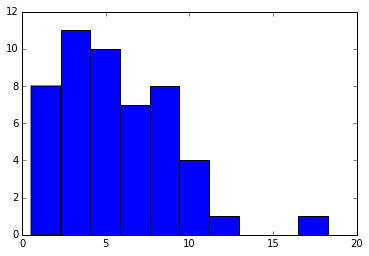

In [3]:
plt.hist(v_arr)

In [4]:
# define the pdfs and likelihood functions

def Rice_dist(x, alpha, beta):
    """the pdf of the Rice distribution for a single value"""
    return (1/alpha)*np.exp((x+beta)/(-alpha))*special.iv(0, 2*np.sqrt(x*beta)/alpha)

def Rice_dist_n(x, alpha, beta):
    """the pdf of the Rice distribution for an array"""
    condlist = [ x>0 ]
    choicelist = [ Rice_dist(x, alpha, beta) ]
    return np.select(condlist, choicelist, default=0.0)
        
def Rice_dist_gen(x, alpha, beta):
    """pdf of Rice distribution that works for single values and array types"""
    print('hi')
    
def gaussian_1param(x, mu):
    """gaussian pdf with variance equal to the mean"""
    return np.exp(-(x-mu)**2/mu)/np.sqrt(2*np.pi*mu)

def neg_likelihood(params, value_array, function):
    """the opposite of the likelihood function for a set of independent values for a given \\
    function"""
    l = -1
    for x in value_array:
        l *= function(x, *params)
    return l


In [5]:
# perform the optimization on both functions
guess = (2, 3)
opt_rice = optimize.fmin(neg_likelihood, guess, args=(v_arr, Rice_dist))
print(opt_rice)

guess = (5,)
opt_gauss = optimize.fmin(neg_likelihood, guess, args=(v_arr, gaussian_1param))
print(opt_gauss)


Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 75
[ 1.12949817  4.50316054]
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 16
         Function evaluations: 32
[ 6.33862305]


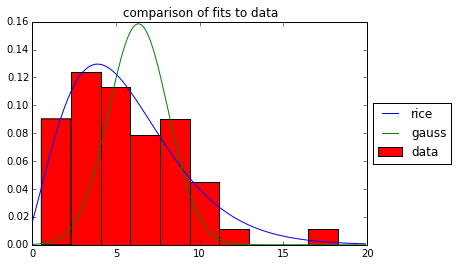

In [6]:
# plot the Rice distribution with optimal values against normed histogram
r = np.arange(0., 20., 0.1)
plt.plot(r, Rice_dist(r, *opt_rice), label='rice')
plt.plot(r, gaussian_1param(r, *opt_gauss), label='gauss')
plt.hist(v_arr, normed=True, label='data')
plt.legend(loc='center left', bbox_to_anchor=(1., 0.5))
plt.title("comparison of fits to data")


<h4> posterior density function for Rice distribution </h4>

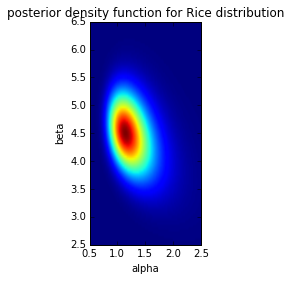

In [7]:
# define a mesh grid for parameter space plot 
alpha_range = np.linspace(0.5, 2.5, 100)
beta_range = np.linspace(2.5, 6.5, 100)
alpha_arr, beta_arr = np.meshgrid(alpha_range, beta_range)

# positive likelihood values for Rice distribution! 
Rice_arr = -neg_likelihood((alpha_arr, beta_arr), v_arr, Rice_dist_n)

# plot the posterior density function
ext = [alpha_range.min(), alpha_range.max(), beta_range.min(), beta_range.max()]
plt.imshow(Rice_arr, extent=ext, origin='lower')
plt.title("posterior density function for Rice distribution")
plt.xlabel('alpha')
plt.ylabel('beta')


In [21]:
# find the ratio of likelihood functions 
ratio = neg_likelihood(opt_rice, v_arr, Rice_dist_n) / neg_likelihood(opt_gauss, v_arr, gaussian_1param)
print(ratio)

2.14157719612e+26


<h2> Problem 2 </h2>

In [8]:
# read in the data and close files 
model_fits = fits.open("hw6prob2_model.fits")
psf_fits = fits.open("hw6prob2_psf.fits")
print(model_fits.info())
print(psf_fits.info())

model_data = model_fits[0].data
psf_data = psf_fits[0].data

model_fits.close()
psf_fits.close()


Filename: hw6prob2_model.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       7   (128, 128, 128)   float64   
None
Filename: hw6prob2_psf.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       6   (64, 64)     float64   
None


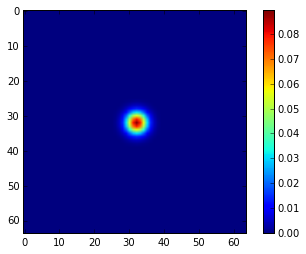

In [9]:
plt.imshow(psf_data)
cbar = plt.colorbar()
cbar.solids.set_edgecolors('face')

Integrating the model along the 0th (slow) dimension. For a discrete array, this amounts to summing across each value in the 0th dimension for each coordinate in the other two dimensions. In most cases there would be a multiplicative factor of the bin width to represent $\delta x$, but here we are doing it in units of pixels with value $1$

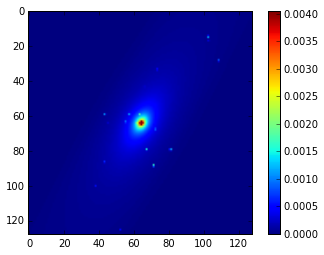

In [10]:
model_data_intgrl = np.sum(model_data, axis=0)
f = plt.figure()
plt.imshow(model_data_intgrl)
cbar = plt.colorbar()
cbar.solids.set_edgecolors('face')

In [11]:
# define FFT functions 

def cool_turkey_fft(arr, N=0, s=1, **kwargs): # inverse=False
    """performs a 1-dimensional fast Fourier transform
    on arr using the Cooley–Tukey algorithm. 
    return: transformed array, ndarray
    keyword arguments: inverse=False
                        performs inverse FFT"""
    if N == 0:
        N = len(arr)
    sign = 1 # sign that goes into exponential, + implies not doing inverse transform
    for key, value in kwargs.items():
        if key == 'inverse':
            sign = -1 
    s = int(s)
    ARR = np.zeros(N, dtype=complex)
    if N == 1:
        ARR[0] = arr[0]
    else:
        N2 = int(N/2)
        ARR[0:N2] = cool_turkey_fft(arr[0::2*s], N2, s, **kwargs)
        ARR[N2:] = cool_turkey_fft(arr[1::2*s], N2, s, **kwargs)
        for k in range(0, N2):
            orig = ARR[k]
            ARR[k] = orig + np.exp(-sign*2*np.pi*(1j)*k/N)*ARR[k+N2]
            ARR[k+N2] = orig - np.exp(-sign*2*np.pi*(1j)*k/N)*ARR[k+N2]
    return ARR

def ifft(arr, fft_method, *args, **kwargs): # =cool_turkey_fft
    """performs inverse of 1d fast Fourier transform"""
    kwargs['inverse'] = True
    ARR = fft_method(arr, *args, **kwargs)
    return ARR / len(ARR)
    
def fft_2d(arr_2d, fft_1d, *args, **kwargs): # =cool_turkey_fft
    """performs a fast Fourier transform in 2 dimensions"""
    # check type of array
    # check dimensions
    nx, ny = arr_2d.shape
    N = nx
    
    ARR_2d = np.zeros((N,N), dtype=np.complex64)
    
    for i in range(0, N):
        ARR_2d[i,:] = fft_1d(arr_2d[i,:], *args, **kwargs)
        
    for j in range(0, N):
        ARR_2d[:,j] = fft_1d(ARR_2d[:,j], *args, **kwargs)
        
    return ARR_2d
        
def zero_pad_symm2d(arr, shape):
    """pads array with 0s, placing original values in the center symmetrically
        returns ndarray of given shape"""
    # check new shape big enough to include old shape 
    sh0 = arr.shape
    ARR = np.zeros(shape)
    
    ARR[int((shape[0]-sh0[0])/2):int((shape[0]+sh0[0])/2), int((shape[1]-sh0[1])/2):int((shape[1]+sh0[1])/2)] = arr
    
    return ARR


<h3> Performing the convolution </h3>
The convulution will just be the product 
First the data arrays are padded with zeros, large enough to include the whole PSF at the edge of the model array  
Then, both arrays are transformed into Fourier space using our defined FFT in 2-dimensions.  
In this space, the convolution is just the element-wise product of each array 
The inverse FFT must be applied to view it in real space  
The result is shifted for some reason, part of the transormation process. We use a numpy function to shift it back 

In [12]:
# do the padding 
size_full = model_data_intgrl.shape[0] + 2*psf_data.shape[0]
psf_data_padded = zero_pad_symm2d(psf_data, (size_full,size_full))
model_data_padded = zero_pad_symm2d(model_data_intgrl, (size_full,size_full))

# FFT the 2D data 
psf_fft = fft_2d(psf_data_padded, cool_turkey_fft)
model_fft = fft_2d(model_data_padded, cool_turkey_fft)



In [13]:
# convolve model with PSF
convoluted_data_fft = psf_fft * model_fft

# inverse FFT to get back to real space
convoluted_data_space = fft_2d(convoluted_data_fft, cool_turkey_fft, inverse=True)

# shift back 
convoluted_data_space = np.fft.fftshift(convoluted_data_space)


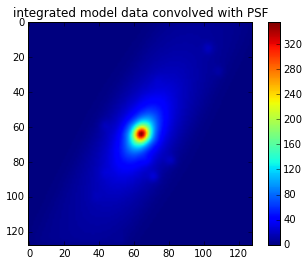

In [14]:
# plot the result, looks good!
f = plt.figure()
plt.imshow(np.real(convoluted_data_space[64:192, 64:192]))
plt.title("integrated model data convolved with PSF")
cbar = plt.colorbar()
cbar.solids.set_edgecolors('face')

other stuff

In [15]:
x = np.linspace(0, 2*np.pi, 128, dtype=complex)
sinar = np.sin(3*x)


In [16]:
sinar_ctfft = cool_turkey_fft(sinar, 128, 1)
sinar_fft_np = np.fft.fft(sinar)


In [17]:
print(v_arr)

[3.268234568833195, 4.559128104426302, 9.952412352739938, 10.653534538036835, 5.838784012707487, 0.537382849676793, 7.700844168450949, 3.5868235601282272, 0.8893756846959922, 2.1763985114475304, 10.691842822083164, 8.391122773785431, 4.501693277379227, 2.622576726010284, 1.5392386446856254, 1.5437725138306102, 1.7699013063829039, 11.47863549609901, 5.125085938794893, 4.766521181897709, 0.9314251647394078, 6.176257938434682, 3.7687951140516374, 3.333455779322836, 4.433195145151503, 3.8722000665260325, 3.261930122936174, 7.579279779356263, 6.1002757807229635, 8.661302055006214, 11.053300867227067, 3.7037028069928812, 5.017700076928644, 8.181742162092064, 4.439296750219612, 3.6709851434633456, 9.373635083780874, 6.661202242753072, 18.255547975785536, 2.404939312768206, 4.613846612388805, 7.840872690360568, 1.467958348163112, 3.6470546198578258, 4.738737096390033, 6.022129175231994, 6.245327787763655, 7.194089565522965, 8.956268828916492, 8.431682218236459]


/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


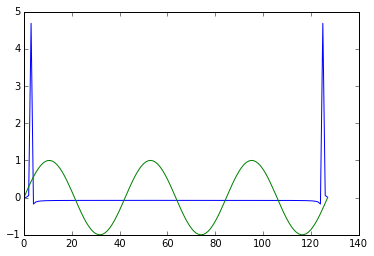

In [18]:

p = plt.plot(np.real(sinar_ctfft))
sinar_fftifft = ifft(sinar_ctfft, cool_turkey_fft, 128, 1)
plt.plot(sinar_fftifft)


In [19]:
     for arg in args:
        print(arg)
    for key, value in kwargs.items():
        print("%s, %s",key,value)

    
    #ARR[0:int(N/2)] = cool_turkey_fft(arr[0::2])
        #ARR[int(N/2)] = cool_turkey_fft(arr[1::2])

        #ARReven = cool_turkey_fft(arr[0::2*s], N/2, s)
        #ARRodd = cool_turkey_fft(arr[s::2*s], N/2, s)


IndentationError: unexpected indent (<ipython-input-19-60b82fa57294>, line 3)

In [ ]:
import mpl_toolkits
mpl_toolkits.mplot3d.Axes3D.contour(model_data)
from mpl_toolkits.mplot3d import Axes3D
Axes3D.contour3D(model_data)

In [ ]:
print((1j)*(1j))
print(sinar)
print(sinar[1::2*1])
np.complex256
optimize.curve_fit?

In [ ]:
for s in (0, 63, 127):
    plt.figure()
    plt.imshow(model_data[s][:][:])
    cbar = plt.colorbar()
    cbar.solids.set_edgecolors('face')